## 0 Install and import dependencies

In [7]:
!pip install opencv-python matplotlib imageio gdown

In [3]:
!pip install tensorflow_gpu==2.10.0

     ---------------------------------------- 0.0/455.9 MB ? eta -:--:--
     -------------------------------------- 0.0/455.9 MB 660.6 kB/s eta 0:11:31
     ---------------------------------------- 0.2/455.9 MB 1.8 MB/s eta 0:04:08
     ---------------------------------------- 0.3/455.9 MB 2.4 MB/s eta 0:03:12
     ---------------------------------------- 0.6/455.9 MB 3.6 MB/s eta 0:02:08
     ---------------------------------------- 1.0/455.9 MB 4.7 MB/s eta 0:01:38
     ---------------------------------------- 1.4/455.9 MB 5.3 MB/s eta 0:01:27
     ---------------------------------------- 1.6/455.9 MB 5.8 MB/s eta 0:01:19
     ---------------------------------------- 1.9/455.9 MB 5.3 MB/s eta 0:01:27
     ---------------------------------------- 2.1/455.9 MB 5.1 MB/s eta 0:01:29
     ---------------------------------------- 2.3/455.9 MB 5.3 MB/s eta 0:01:26
     ---------------------------------------- 2.6/455.9 MB 5.4 MB/s eta 0:01:25
     ---------------------------------------- 2

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio

In [160]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices=tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    pass

## 1 Build Data loading functions

In [5]:
import gdown

In [6]:
url='https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output='data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')


Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=4e4cdf6a-93c4-4476-92d9-45ec0bd2e477
To: C:\Users\srina\DL projects\data.zip
100%|██████████| 423M/423M [01:42<00:00, 4.12MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [6]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        # this indexes are used to get only the mouth region
        #original paper using Dlib to isolate the mouth, but here its done statistically
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(tf.cast(frames, tf.float32))
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    return tf.cast((frames - mean), tf.float32) / std


In [7]:
# vocab is simply every single character we can expect in annotation
vocab= [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num(["s","r","i"])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([19, 18,  9], dtype=int64)>

In [12]:
num_to_char([19,18,9])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b's', b'r', b'i'], dtype=object)>

In [13]:
#Loading alignments
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('\\')[-1].split('.')[0]
    video_path=os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    return frames,alignments
    

In [15]:
test_path='.\\data\\s1\\bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [17]:
frames,alignments=load_data(tf.convert_to_tensor(test_path))

In [18]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4467558 ],
         [ 1.4467558 ],
         [ 1.4072862 ],
         ...,
         [ 0.14426002],
         [ 0.18372959],
         [ 0.06532088]],

        [[ 1.4467558 ],
         [ 1.4467558 ],
         [ 1.4072862 ],
         ...,
         [ 0.14426002],
         [ 0.06532088],
         [ 0.02585131]],

        [[ 1.4072862 ],
         [ 1.4072862 ],
         [ 1.3678166 ],
         ...,
         [ 0.06532088],
         [ 0.06532088],
         [ 0.06532088]],

        ...,

        [[ 0.9336514 ],
         [ 0.9336514 ],
         [ 0.9336514 ],
         ...,
         [-0.17149653],
         [-0.25043565],
         [-0.25043565]],

        [[ 0.9336514 ],
         [ 0.9336514 ],
         [ 0.9336514 ],
         ...,
         [-0.2109661 ],
         [-0.25043565],
         [-0.25043565]],

        [[ 0.9336514 ],
         [ 0.9336514 ],
         [ 0.9336514 ],
         ...,
         [-0.2109661 ],
         [-0.25043

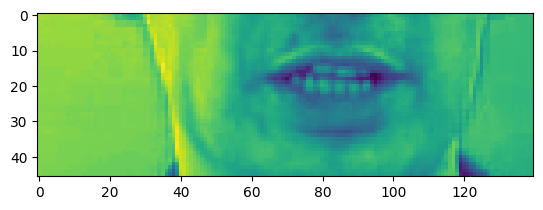

In [19]:
plt.imshow(frames[40])

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
# tf data pipelines require us to wrap pure strings in tf.py_function to use them
def mappable_function(path:str)->List[str]:
    result=tf.py_function(load_data,[path],(tf.float32,tf.int64))
    return result

## 2 Create Data Pipeline

In [22]:
data=tf.data.Dataset.list_files('./data/s1/*.mpg')
data=data.shuffle(500,reshuffle_each_iteration=False)
data=data.map(mappable_function)
# batching into size of 2 : 2 vid and 2 align 1
#ensuring we have 75 frames and 40 tokens for alignments
# if less than 40 then padded to 0
data=data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
data=data.prefetch(tf.data.AUTOTUNE)

In [23]:
train=data.take(450)
test=data.skip(450)

In [24]:
len(test)

50

In [25]:
frames,alignments=data.as_numpy_iterator().next()

In [26]:
alignments

array([[ 2,  9, 14, 39,  7, 18,  5,  5, 14, 39, 23,  9, 20,  8, 39, 21,
        39, 14,  9, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  2, 25, 39, 14, 39, 20,
         8, 18,  5,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [27]:
len(frames)

2

In [28]:
test=data.as_numpy_iterator()

In [29]:
val=test.next();val[0]
# val 0 for frames

array([[[[[ 1.3363903 ],
          [ 1.3728185 ],
          [ 1.4821031 ],
          ...,
          [ 0.38925654],
          [ 0.35282832],
          [ 0.35282832]],

         [[ 1.299962  ],
          [ 1.4092467 ],
          [ 1.4092467 ],
          ...,
          [ 0.38925654],
          [ 0.35282832],
          [ 0.35282832]],

         [[ 1.4821031 ],
          [ 1.4821031 ],
          [ 1.5185313 ],
          ...,
          [ 0.38925654],
          [ 0.35282832],
          [ 0.35282832]],

         ...,

         [[ 1.0449644 ],
          [ 1.0449644 ],
          [ 1.0449644 ],
          ...,
          [ 0.02497436],
          [ 0.02497436],
          [-0.04788207]],

         [[ 1.0449644 ],
          [ 1.0449644 ],
          [ 1.0449644 ],
          ...,
          [ 0.13425902],
          [ 0.13425902],
          [ 0.0978308 ]],

         [[ 1.0449644 ],
          [ 1.0449644 ],
          [ 1.0449644 ],
          ...,
          [ 0.0978308 ],
          [ 0.0978308 ],
          

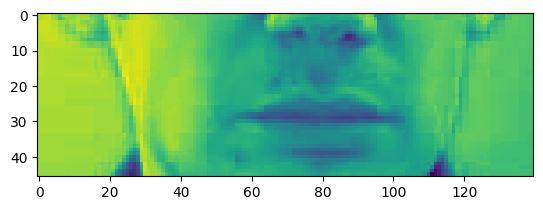

In [31]:
# 0:videos , 0 : 1st video of batch , 0 : 1st frame of the vide0
plt.imshow(val[0][0][0])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green with o five again'>

## 3 Design the deep neural network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,LSTM,Dense,Dropout,Bidirectional,MaxPool3D,Activation,Reshape,SpatialDropout3D,BatchNormalization,TimeDistributed,Flatten

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [95]:
# model = Sequential()
# model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(64, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(64, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(TimeDistributed(Flatten()))

# model.add(Bidirectional(LSTM(64, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# model.add(Bidirectional(LSTM(64, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

model = Sequential()

model.add(Conv3D(64, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(32, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(32, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


In [37]:
char_to_num.vocabulary_size()

40

In [38]:
# output should be 75,41 : one output per frame , 1 hot for each prediction

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 64)    221248    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 64)    0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 64)   0         
 3D)                                                    

In [40]:
yhat=model.predict(val[0]) # without training

1/1 [==============================] - 6s 6s/step


In [41]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'xxxxmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm'>

In [42]:
yhat[0]

array([[0.02544298, 0.02532473, 0.02513014, ..., 0.02445315, 0.02446864,
        0.02549027],
       [0.02529848, 0.02557792, 0.02483076, ..., 0.02449546, 0.02492509,
        0.02555024],
       [0.02514223, 0.02579923, 0.02448985, ..., 0.02454482, 0.02526963,
        0.02562908],
       ...,
       [0.02366312, 0.02597206, 0.02207777, ..., 0.0258911 , 0.02535659,
        0.02633635],
       [0.02351295, 0.02567788, 0.02218512, ..., 0.02590353, 0.0251328 ,
        0.02614197],
       [0.02336071, 0.02527874, 0.02237465, ..., 0.02586735, 0.02490975,
        0.02604647]], dtype=float32)

In [43]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([24, 24, 24, 24, 37, 37, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13], dtype=int64)>

In [44]:
model.input_shape

(None, 75, 46, 140, 1)

In [45]:
model.output_shape

(None, 75, 41)

## 4 Setup Training Options and Train

In [46]:
def scheduler(epoch ,lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [47]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [85]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = iter(dataset)

    def on_epoch_end(self, epoch, logs=None) -> None:
        try:
            data = self.dataset.__next__()  # For Python 3.7 and above
            # Alternatively, use the following for Python 3.6 and earlier:
            # data = next(self.dataset)
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        except StopIteration:
            # Reset the iterator when the dataset is exhausted
            self.dataset = iter(dataset)


In [96]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss)

In [97]:
checkpoint_callback=ModelCheckpoint(os.path.join('models','checkpoint'),monitor='loss',save_weights=True)

In [98]:
schedule_callback=LearningRateScheduler(scheduler)

In [99]:
print(type(test))

<class 'tensorflow.python.data.ops.dataset_ops._NumpyIterator'>


In [100]:
example_callback = ProduceExample(model, test)


In [101]:
model.fit(train, validation_data=test, epochs=100,steps_per_epoch=450, validation_steps=50,callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
450/450 [==============================] - ETA: 0s - loss: 114.0856

StopIteration: 